In [2]:
%matplotlib inline

In [3]:
import torch
import torch.nn as nn

In [4]:
from pdb import set_trace

In [5]:
class LabelSmoothingLoss(nn.Module):
    
    def __init__(self, dim=-1):
        super().__init__()
        self.dim = dim

    def forward(self, one_hot_target, preds):
        preds = preds.log_softmax(dim=self.dim)
        return torch.mean(torch.sum(-one_hot_target * preds, dim=self.dim))

In [6]:
from catalyst.utils import get_one_hot

In [7]:
# y_true = torch.tensor([1, 1, 0, 2, 1])

# y_pred_1 = torch.tensor([
#     [0.19, 0.8, 0.01],
#     [0.82, 0.08, 0.1],
#     [0.9, 0.05, 0.05],
#     [0.2, 0.2, 0.6],
#     [0.9, 0.07, 0.03]
# ])

# y_pred_2 = torch.tensor([
#     [0.00, 1.00, 0.00],
#     [0.00, 1.00, 0.00],
#     [1.00, 0.00, 0.00],
#     [0.00, 0.00, 1.00],
#     [0.00, 1.00, 0.00]
# ])

# y_true_onehot = torch.tensor([get_one_hot(x, 3, 0.1) for x in y_true])

# loss_fn = LabelSmoothingLoss(3)
# print(loss_fn(y_pred_1, y_true))
# print(loss_fn(y_pred_2, y_true))

In [8]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, _LRScheduler
import numpy as np

In [9]:
class CosineDecay(_LRScheduler):
    def __init__(self, optimizer, total_steps,
                 linear_start=0,
                 linear_frac=0.1, min_lr=1e-6,
                 last_epoch=-1):
        
        self.optimizer = optimizer
        self.total_steps = total_steps
        self.linear_start = linear_start
        self.linear_frac = linear_frac
        self.min_lr = min_lr
        self.linear_steps = total_steps * linear_frac
        self.cosine_steps = total_steps - self.linear_steps
        super().__init__(optimizer, last_epoch)
        
    def get_lr(self):
        step = self.last_epoch
        if step <= self.linear_steps:
            b = self.linear_start
            return [(step/self.linear_steps) * (base_lr - b) + b for base_lr in self.base_lrs]
        else:
            t = self.last_epoch - self.linear_steps
            T = self.cosine_steps
            return [self.min_lr + (base_lr - self.min_lr)*(1 + np.cos(t*np.pi/T))/2
                    for base_lr in self.base_lrs]

In [10]:
import torch.nn.functional as F

In [11]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(3, 32, 3)
        self.c2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, 10)
    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = self.pool(x).squeeze()
        x = self.fc(x)
        return x

In [12]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

In [21]:
input_tensor = torch.ones((16, 3, 32, 32))
m = Model()
max_lr = 1e-3

opt = torch.optim.AdamW(m.parameters(), lr=1.0)

n = 120
lrs = []
index = 0
epochs = 10
warmup_steps = 3
eta_min = 0.1

sched = CosineAnnealingWarmRestarts(opt, T_0=n, T_mult=2, eta_min=eta_min)

for epoch in range(1, epochs + 1):
    if epoch == (warmup_steps + 1):
        sched = CosineDecay(opt, (epochs-warmup_steps)*n, linear_frac=0.1, linear_start=eta_min)
        index = 0
    for i in range(n):
        index += 1
        if epoch == warmup_steps and i == (n - 1):
            pass
        else:
            sched.step(index)
        lrs.append(sched.get_lr())
lrs = np.array(lrs)

In [22]:
import matplotlib.pyplot as plt

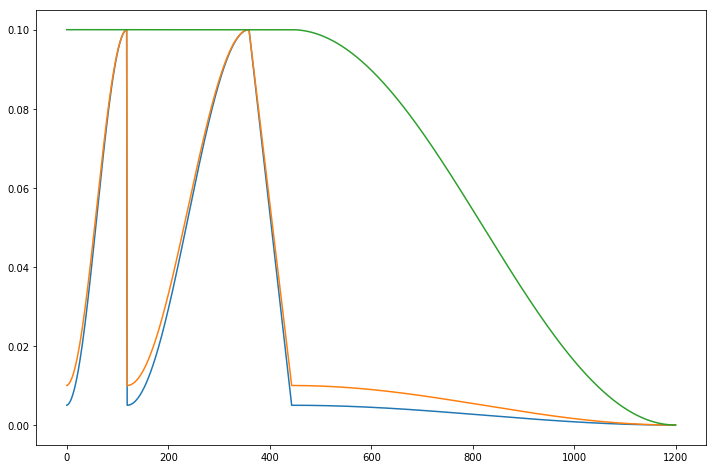

In [23]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(lrs[:, 0])
ax.plot(lrs[:, 1])
ax.plot(lrs[:, 2])

In [43]:
input_tensor = torch.ones((16, 3, 32, 32))
m = Model()
base_lr = 1.0

opt = torch.optim.AdamW(params=[
    {'params': m.c1.parameters(), 'lr': base_lr/3},
    {'params': m.c2.parameters(), 'lr': base_lr/5},
    {'params': m.fc.parameters(), 'lr': base_lr/10}
])

n = 120
lrs = []
index = 0
epochs = 10
warmup_steps = 3
eta_min = 0.1

sched = CosineDecay(
    opt, epochs*n, linear_frac=0.1, 
    linear_start=base_lr / 100,
    min_lr=base_lr / 300)

for epoch in range(1, epochs + 1):
    for _ in range(n):
        sched.step()
        lrs.append(sched.get_lr())
    
lrs = np.array(lrs)

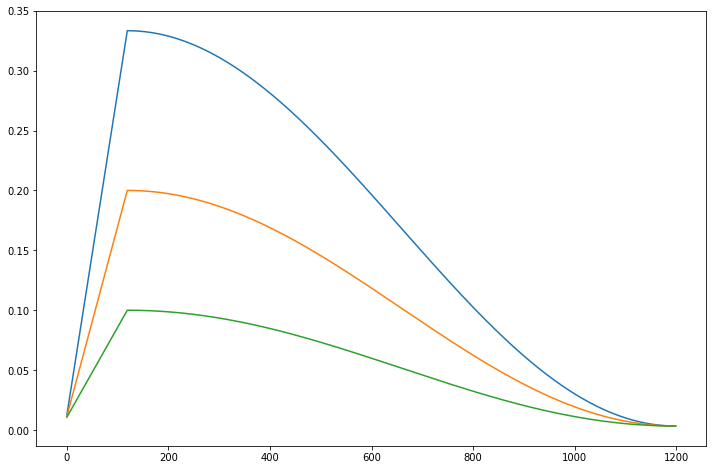

In [44]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(lrs[:, 0])
ax.plot(lrs[:, 1])
ax.plot(lrs[:, 2])

In [25]:
from apex import amp
opt_level = 'O1'
m = m.to('cuda:0')
m, opt = amp.initialize(m, opt, opt_level=opt_level, num_losses=1)

KeyboardInterrupt: 

In [18]:
import gluoncvth as gcv

RuntimeError: Could not get qualified name for class 'log': __module__ can't be None.

In [20]:
!pip list | egrep torch

gluoncv-torch                     0.0.3           
pytorch-ignite                    0.1.1           /home/ck/code/open_source/ignite   
pytorch-pretrained-bert           0.6.2           
torch                             1.2.0           
torchfile                         0.1.0           
torchvision                       0.4.0a0+6b959ee 
torchvision-nightly               0.2.1           


In [17]:
!pip install gluoncv-torch